In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/QUASR

/content/drive/.shortcut-targets-by-id/1UNftLhttsehtg8sufPOwStG59bhgVpM6/QUASR


In [ ]:
import numpy as np
import pandas as pd

# to load the data set
dfo = pd.read_pickle('QUASR.pkl')
xo = np.load('dofs.npy')

In [ ]:
dfo.shape ##our ys?

(371421, 30)

In [ ]:
xo.shape ##our xs?

(371421, 661)

1. `ddpm_tiny.py`: contains an unconditional Unet with MLP backbone $f(x_t, t)$, takes noisy input with dimension $x_t \in \mathbb R^d$;
2. TODO: tweak $f$ as a conditional diffusion model. For example:
 - classifier-free: augment noisy input with clean conditions, i.e. $x_t \mapsto [x_t; y]$ (see an example [here](https://huggingface.co/learn/diffusion-course/en/unit2/3))
 - classifier-guided: train $f$ as an unconditional model given only $\{x \}$; train another classifier (or regressor) $g$ that takes in noisy input and outputs labels. Then modify the DDPM backward process, using the classifier gradient to guide the sampling process.

In [ ]:
from ddpm_fusion import *

In [ ]:
!python ddpm_fusion.py --num_timesteps 200 --num_epochs 1000 --hidden_size 64  --hidden_layers 1 --return_pca --train_batch_size 128 --save_images_step 5 --embedding_size 64

In [26]:
!python ddpm_fusion.py --num_timesteps 200 --num_epochs 1000 --hidden_size 128  --hidden_layers 1 --return_pca --train_batch_size 128 --save_images_step 5 --embedding_size 64

Experiment Setting:
| model_type: MLP
| dataset: fig11
| train_batch_size: 128
| eval_batch_size: 128
| num_epochs: 1000
| learning_rate: 0.001
| num_timesteps: 200
| beta_schedule: linear
| embedding_size: 64
| hidden_size: 128
| hidden_layers: 1
| time_embedding: sinusoidal
| save_images_step: 5
| seed: 999
| return_pca: True
MLP(
  (time_mlp): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (joint_mlp): Sequential(
    (0): Linear(in_features=66, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Block(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): GELU(approximate='none')
    )
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)
Training model...
epoch = 0, step = 1, loss = 1.1543965339660645
epoch = 0, step = 2, loss = 1.0840115547180176
epoch = 0, step = 3, loss = 1.056821584701538
epoch = 0, step = 4, loss = 0.8733049631118774
epoch = 0, step = 5, loss = 1.016715168952942
epoch = 50, step = 251, los

In [ ]:
!python ddpm_fusion.py --num_timesteps 200 --num_epochs 1000 --hidden_size 128  --hidden_layers 3 --return_pca --train_batch_size 128 --embedding_size 64

In [28]:
!python ddpm_fusion.py --num_timesteps 200 --num_epochs 10000 --hidden_size 128  --hidden_layers 3 --return_pca --train_batch_size 128 --embedding_size 64

Experiment Setting:
| model_type: MLP
| dataset: fig11
| train_batch_size: 128
| eval_batch_size: 128
| num_epochs: 10000
| learning_rate: 0.001
| num_timesteps: 200
| beta_schedule: linear
| embedding_size: 64
| hidden_size: 128
| hidden_layers: 3
| time_embedding: sinusoidal
| save_images_step: 1000
| seed: 999
| return_pca: True
MLP(
  (time_mlp): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (joint_mlp): Sequential(
    (0): Linear(in_features=66, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Block(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): GELU(approximate='none')
    )
    (3): Block(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): GELU(approximate='none')
    )
    (4): Block(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): GELU(approximate='none')
    )
    (5): Linear(in_features=128, out_features=2, bias=True)
  )
)
Training model...
epoch 

### Generate movies

In [3]:
!pip install celluloid

In [8]:
from celluloid import Camera
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
from ddpm_fusion import * #plot_image_denoising, MLP, GaussianDiffusion

In [21]:
dataset = "fig11"
num_timesteps = 200
beta_schedule = "linear"
hidden_size = 128
hidden_layers = 3 #1
input_dim = 2
embedding_size = 64
num_epochs = 10000
outdir = f"ddpm_tiny_exps/{dataset}_{num_timesteps}_hidden={hidden_size}_layer={hidden_layers}_schedule={beta_schedule}_epoch={num_epochs}"


In [32]:
seed = 99
eval_batch_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'
set_seed(seed)
imgdir =  f"{outdir}/images"

In [27]:
X = figure_11_data(return_pca=True)

In [16]:
model = MLP(hidden_size=hidden_size,
            hidden_layers=hidden_layers,
            emb_size= embedding_size,
            input_dim = input_dim)

diffusion = GaussianDiffusion(
        model,
        num_timesteps=num_timesteps,
        beta_schedule=beta_schedule)

In [22]:
diffusion.load_state_dict(torch.load(f"{outdir}/model.pth", map_location=torch.device('cpu')))
#diffusion.load_state_dict(torch.load("ddpm_tiny_exps/fig11_200_hidden=128_layer=3_schedule=linear_epoch=10000/model.pth", map_location=torch.device('cpu')))
diffusion.eval()

<ipython-input-22-17a254c5c7d8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diffusion.load_state_dict(torch.load(f"{outdir}/model.pth", map_location=torch.device('cpu')

GaussianDiffusion(
  (model): MLP(
    (time_mlp): PositionalEmbedding(
      (layer): SinusoidalEmbedding()
    )
    (joint_mlp): Sequential(
      (0): Linear(in_features=66, out_features=128, bias=True)
      (1): GELU(approximate='none')
      (2): Block(
        (ff): Linear(in_features=128, out_features=128, bias=True)
        (act): GELU(approximate='none')
      )
      (3): Block(
        (ff): Linear(in_features=128, out_features=128, bias=True)
        (act): GELU(approximate='none')
      )
      (4): Block(
        (ff): Linear(in_features=128, out_features=128, bias=True)
        (act): GELU(approximate='none')
      )
      (5): Linear(in_features=128, out_features=2, bias=True)
    )
  )
)

In [25]:
#generating!
diffusion.model.eval()
set_seed(seed)
sample = torch.randn(eval_batch_size, input_dim).to(device)
frames = []
timesteps = list(range(diffusion.num_timesteps))[::-1] #reverse sampling
for i, t in enumerate(timesteps):
    t = torch.from_numpy(np.repeat(t, eval_batch_size)).long().to(device)
    with torch.no_grad():
        residual = diffusion.backward(sample, t)
    sample = diffusion.step(residual, t[0], sample)
    if device != 'cpu':
        sample = sample.to('cpu')
    frames.append(sample) #global epoch changes

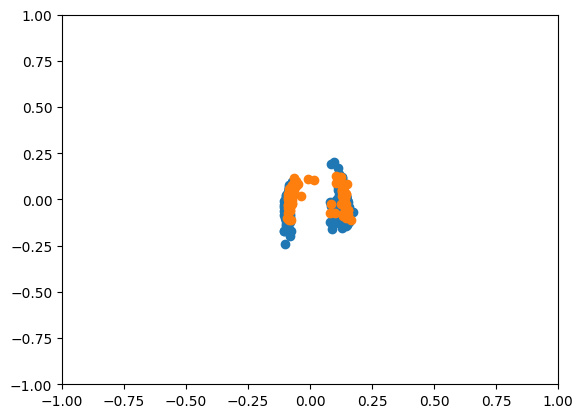

In [35]:
plot_image_denoising(imgdir, frames, basis=None, seed=99, img_train=X)